In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
%matplotlib inline

# Data collection

## Load data

Load daily food log

In [99]:
food = pd.read_csv('food.csv', parse_dates=['date'])
food.head()

,date,name,type,quantity,units,calories,fat,protein,carb,saturated_fat,sugar,fiber,cholesterol,sodium
0,2018-08-29,"Egg, Fried, Large",Breakfast,50.0,Grams,98,7.66,6.81,0.45,2.15,0.42,0.00,228.50,102.0
1,2018-08-29,"Fish Ball, Asian Style, Cooked",Breakfast,153.0,Grams,116,1.22,18.82,6.88,0.31,2.14,0.00,110.16,994.5
2,2018-08-29,"Green Beans, Cooked",Breakfast,50.0,Grams,18,0.14,0.95,3.94,0.30,1.82,1.60,0.00,0.5
3,2018-08-29,"Soup, Egg Drop, Restaurant",Breakfast,3.0,Cups,195,4.41,8.39,31.20,1.16,0.65,2.89,166.29,2675.1
4,2018-08-29,"Egg, Fried, Large",Lunch,50.0,Grams,98,7.66,6.81,0.45,2.15,0.42,0.00,228.50,102.0


In [100]:
daily_cal = food.groupby('date')['calories'].sum()

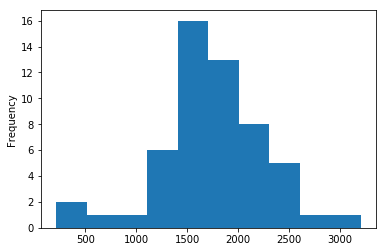

In [101]:
daily_cal.plot.hist()
plt.show()

In [136]:
budget = pd.read_csv('budget.csv', parse_dates=['date'], index_col=0, squeeze=True)
steps = pd.read_csv('steps.csv', parse_dates=['date'], index_col=0, squeeze=True)
weights = pd.read_csv('weights.csv', parse_dates=['date'], index_col=0)

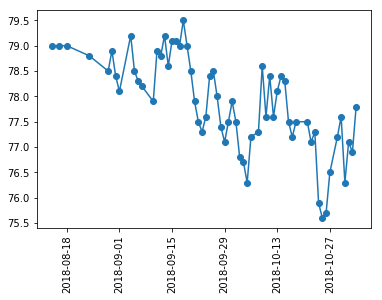

In [139]:
plt.plot(weights.index, weights['weight'].values, marker='o')
plt.xticks(rotation=90)
plt.show()

In [84]:
weights

,1
0,
2018-08-14,79.0
2018-08-16,79.0
2018-08-18,79.0
2018-08-24,78.8
2018-08-29,78.5
2018-08-30,78.9
2018-08-31,78.4
2018-09-01,78.1
2018-09-04,79.2


In [83]:
weights.reindex(weights.index + pd.Timedelta(1, unit='D'))

,1
0,
2018-08-15,NaN
2018-08-17,NaN
2018-08-19,NaN
2018-08-25,NaN
2018-08-30,78.9
2018-08-31,78.4
2018-09-01,78.1
2018-09-02,NaN
2018-09-05,78.5


In [73]:
weights['Tomorrow weight'] = weights.reindex(weights.index + pd.Timedelta(1, unit='D')).values
weight['Weight gain'] = weight['Tomorrow weight'] - weight['Weight']
weight

NameError: name 'weight' is not defined

In [221]:
df_joined = pd.concat([daily_cal, weight, budget_step], axis=1)
df = df_joined.dropna().copy()

In [222]:
df['Calories surplus'] = df['Calories'] - df['Budget']

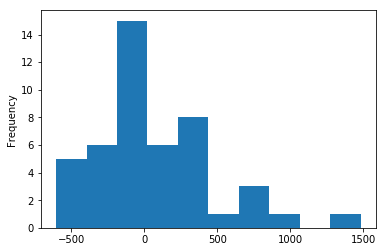

In [223]:
df['Calories surplus'].plot.hist()

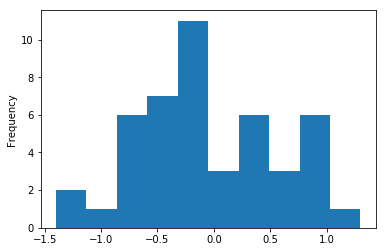

In [225]:
df['Weight gain'].plot.hist()

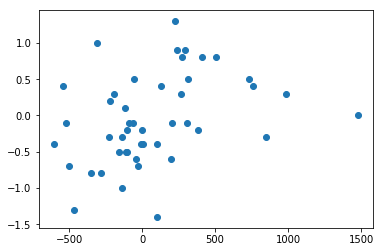

In [226]:
plt.scatter(df['Calories surplus'], df['Weight gain'])

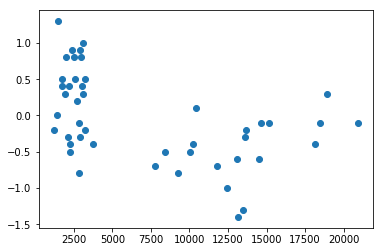

In [227]:
plt.scatter(df['Steps'], df['Weight gain'])

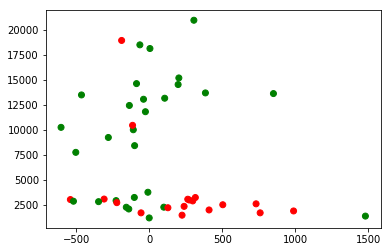

In [228]:
plt.scatter(df['Calories surplus'], df['Steps'], color=list(np.where(df['Weight gain'] > 0, 'Red', 'Green')))

In [229]:
X = df[['Calories surplus', 'Steps']]
y = df['Weight gain'] > 0

In [230]:
y_train.value_counts()

False    22
True     12
Name: Weight gain, dtype: int64

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34, 2), (12, 2), (34,), (12,))

In [232]:
log = LogisticRegression(random_state=42)

In [233]:
y_pred_cv = cross_val_predict(log, X_train, y_train, cv=5)

In [234]:
confusion_matrix(y_train, y_pred_cv)

array([[20,  2],
       [ 8,  4]])

In [235]:
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [236]:
log.coef_

array([[ 0.00107386, -0.00013623]])